In [22]:
import xarray as xr
from glob import glob
import pandas as pd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map
import os
from pprint import pprint
wave_wind_mapping = {
    # Combined Wave Parameters
    "Hsig": "HTSGW",       # Hsig: Significant wave height -> HTSGW: Significant Height of Combined Wind Waves and Swell
    "Dir": "DIRPW",      # PkDir: Peak wave direction -> DIRPW: Direction of Combined Wind Waves and Swell (Often peak direction is reported as the primary direction)
    "Tm01": "PERPW",       # Tm01: Mean wave period (m01) -> PERPW: Mean Period of Combined Wind Waves and Swell (Tm01 is a common representation for mean period)
    # Wind Parameters
    #"Windv_x": "UGRD",     # Windv_x: Horizontal component of wind velocity -> UGRD: U-component of wind
    #"Windv_y": "VGRD",     # Windv_y: Vertical component of wind velocity (Likely intended as the other horizontal component) -> VGRD: V-component of wind
}
ds = xr.open_dataset("NZ_GEFS/NZ_GEFS.nc")
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (latitude: 61, longitude: 60, time: 58384)
Coordinates:
  * latitude   (latitude) float64 488B -33.0 -33.25 -33.5 ... -47.5 -47.75 -48.0
  * longitude  (longitude) float64 480B 165.0 165.3 165.5 ... 179.3 179.5 179.8
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2020-01-01
Data variables:
    swh        (time, latitude, longitude) float32 855MB ...
    dirpw      (time, latitude, longitude) float32 855MB ...
    perpw      (time, latitude, longitude) float32 855MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs_wave_reforecast
    product:                 GEFSv12/wave_reforecast
    description:             NOAA Wave Ensemble Reforecast
    remote_grib:             https://noaa-nws-gefswaves-reforecast-pds.s3.ama...
    local_grib:              GEFS/gefs_wave_reforecast/20000108/subset_b4ef68...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

In [17]:
GEFS_mean = ds.mean()
GEFS_std = ds.std()
GEFS_mean, GEFS_std

(<xarray.Dataset> Size: 12B
 Dimensions:  ()
 Data variables:
     swh      float32 4B 2.704
     dirpw    float32 4B 206.7
     perpw    float32 4B 12.03,
 <xarray.Dataset> Size: 12B
 Dimensions:  ()
 Data variables:
     swh      float32 4B 1.205
     dirpw    float32 4B 71.29
     perpw    float32 4B 2.892)

In [18]:
NI = xr.open_dataset("Joao/NI.nc", decode_times=False)
display(NI)
NI_mean = NI.mean()
NI_std = NI.std()
NI_mean, NI_std

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 58440, latitude: 103, longitude: 100)
Coordinates:
  * time       (time) float64 468kB 1.753e+05 1.753e+05 ... 3.506e+05 3.506e+05
  * latitude   (latitude) float32 412B -42.99 -42.9 -42.81 ... -33.56 -33.46
  * longitude  (longitude) float32 400B 170.4 170.5 170.6 ... 179.4 179.5 179.6
Data variables:
    Dir        (time, latitude, longitude) float64 5GB ...
    Hsig       (time, latitude, longitude) float64 5GB ...
    RTm01      (time, latitude, longitude) float64 5GB ...

(<xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 192.3
     Hsig     float64 8B 2.354
     RTm01    float64 8B 7.523,
 <xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 86.61
     Hsig     float64 8B 1.118
     RTm01    float64 8B 1.861)

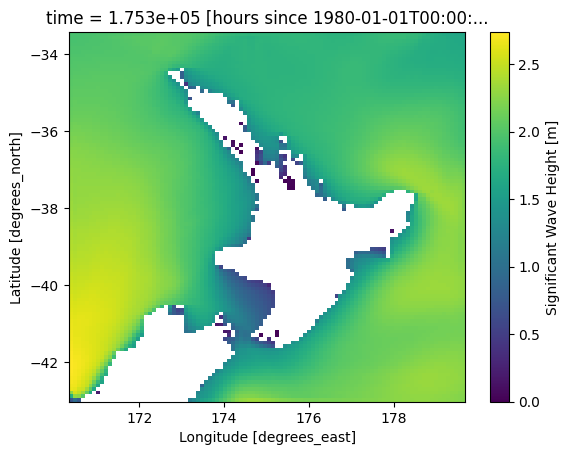

In [26]:
NI.Hsig[0].plot()

In [19]:
SI = xr.open_dataset("Joao/SI.nc", decode_times=False)
display(SI)
SI_mean = SI.mean()
SI_std = SI.std()
SI_mean, SI_std

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 58440, latitude: 103, longitude: 121)
Coordinates:
  * time       (time) float64 468kB 1.753e+05 1.753e+05 ... 3.506e+05 3.506e+05
  * latitude   (latitude) float32 412B -48.04 -47.94 -47.85 ... -38.6 -38.51
  * longitude  (longitude) float32 484B 165.6 165.7 165.8 ... 176.6 176.7 176.8
Data variables:
    Dir        (time, latitude, longitude) float64 6GB ...
    Hsig       (time, latitude, longitude) float64 6GB ...
    RTm01      (time, latitude, longitude) float64 6GB ...

(<xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 220.3
     Hsig     float64 8B 2.965
     RTm01    float64 8B 8.531,
 <xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 70.25
     Hsig     float64 8B 1.288
     RTm01    float64 8B 1.765)

In [23]:
stats = {
    "input": {
        "swh": {"mean": GEFS_mean.to_dict()["data_vars"]["swh"]["data"], "std": GEFS_std.to_dict()["data_vars"]["swh"]["data"]},
        "dirpw": {"mean": GEFS_mean.to_dict()["data_vars"]["dirpw"]["data"], "std": GEFS_std.to_dict()["data_vars"]["dirpw"]["data"]},
        "perpw": {"mean": GEFS_mean.to_dict()["data_vars"]["perpw"]["data"], "std": GEFS_std.to_dict()["data_vars"]["perpw"]["data"]},
    },
    "output": {
        "NI": {
            "Hsig": {"mean": NI_mean.to_dict()["data_vars"]["Hsig"]["data"], "std": NI_std.to_dict()["data_vars"]["Hsig"]["data"]},
            "Dir": {"mean": NI_mean.to_dict()["data_vars"]["Dir"]["data"], "std": NI_std.to_dict()["data_vars"]["Dir"]["data"]},
            "RTm01": {"mean": NI_mean.to_dict()["data_vars"]["RTm01"]["data"], "std": NI_std.to_dict()["data_vars"]["RTm01"]["data"]},
        },
        "SI": {
            "Hsig": {"mean": SI_mean.to_dict()["data_vars"]["Hsig"]["data"], "std": SI_std.to_dict()["data_vars"]["Hsig"]["data"]},
            "Dir": {"mean": SI_mean.to_dict()["data_vars"]["Dir"]["data"], "std": SI_std.to_dict()["data_vars"]["Dir"]["data"]},
            "RTm01": {"mean": SI_mean.to_dict()["data_vars"]["RTm01"]["data"], "std": SI_std.to_dict()["data_vars"]["RTm01"]["data"]},
        },
    }
}
pprint(stats)

{'input': {'dirpw': {'mean': 206.71180725097656, 'std': 71.2880859375},
           'perpw': {'mean': 12.027607917785645, 'std': 2.891993284225464},
           'swh': {'mean': 2.704122304916382, 'std': 1.2054082155227661}},
 'output': {'NI': {'Dir': {'mean': 192.25671572175946,
                           'std': 86.61004785128885},
                   'Hsig': {'mean': 2.3537522749671487,
                            'std': 1.1175191556747635},
                   'RTm01': {'mean': 7.523491293640128,
                             'std': 1.8608034067936419}},
            'SI': {'Dir': {'mean': 220.32824446666498,
                           'std': 70.24578443716693},
                   'Hsig': {'mean': 2.9651013589459585,
                            'std': 1.2882138423923746},
                   'RTm01': {'mean': 8.531020040354104,
                             'std': 1.7649841649550069}}}}
